# Import Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import gc
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lib_file import lib_path
import random
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

ModuleNotFoundError: No module named 'cv2'

In [3]:
BASE_DIR = "input"

class_labels = os.listdir(BASE_DIR)
class_labels.sort()

print(class_labels)

['basketball', 'biking', 'diving', 'horse_riding']


In [4]:
video_paths = []
targets = []

for target in tqdm(class_labels):
    target_path = os.path.join(BASE_DIR, target)
    sub_target_folders = os.listdir(target_path)
    for subfolder in sub_target_folders:
        if str(subfolder).lower() != "annotation":
            sub_target_folder_path = os.path.join(target_path, subfolder)
            video_files = os.listdir(sub_target_folder_path)
            video_files = [os.path.join(sub_target_folder_path, file_) for file_ in video_files]
            video_paths.extend(video_files)
            targets.extend([target]*len(video_files))

NameError: name 'tqdm' is not defined

In [5]:
df = pd.DataFrame()
df['video_paths'] = video_paths
df['targets'] = targets

df.head()

NameError: name 'pd' is not defined

In [6]:
df.tail()

NameError: name 'df' is not defined

In [7]:
df.shape

NameError: name 'df' is not defined

In [8]:
df['targets'].value_counts()

NameError: name 'df' is not defined

In [9]:
chart_data = dict(df['targets'].value_counts())
with plt.style.context(style="fivethirtyeight"):
    plt.figure(figsize=(8,5))
    plt.rcParams['font.size'] = 15
    plt.bar(x=list(chart_data.keys()),
           height=list(chart_data.values()))
    plt.title(label="Bar-chart with 'targets' feature", fontsize=20)
    plt.xlabel(xlabel="Targets", fontsize=15)
    plt.ylabel(ylabel="Number of samples", fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    for x, y in zip(chart_data.keys(), chart_data.values()):
        plt.text(x, y, str(y), ha='center', va='bottom')
    plt.show()

NameError: name 'df' is not defined

In [10]:
chart_data = dict(df['targets'].value_counts())
with plt.style.context(style="fivethirtyeight"):
    plt.figure(figsize=(8,5))
    plt.rcParams['font.size'] = 15
    plt.pie(labels=list(chart_data.keys()),
           x=list(chart_data.values()),
           autopct="%.2f%%")
    plt.title(label="Pie-chart with 'targets' feature", fontsize=20)
    plt.show()

NameError: name 'df' is not defined

In [11]:
class_dict = {}
for idx, label in enumerate(class_labels):
    class_dict[label] = idx

print(class_dict)

{'basketball': 0, 'biking': 1, 'diving': 2, 'horse_riding': 3}


In [12]:
df['targets'] = df['targets'].map(class_dict)
df.head()

NameError: name 'df' is not defined

In [13]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

NameError: name 'df' is not defined

# Data Loading

In [14]:
data_length = 20
image_height = 96
image_width = 96
frames = []
target_labels = []

for video_path, numerical_label in tqdm(zip(df['video_paths'].values.tolist(), df['targets'].values.tolist()), total=len(df)):
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    if video_frames_count >= data_length:
        skip_frames_window = max(int(video_frames_count / data_length), 1)
        frames_list = []
        for frame_counter in range(data_length):
            target_frame_position = round(frame_counter * skip_frames_window)
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, target_frame_position)
            success, frame = video_reader.read()
            if not success:
                break
            resized_frame = cv2.resize(frame, (image_height, image_width))
            normalized_frame = resized_frame / 255.0
            frames_list.append(normalized_frame)
        video_reader.release()
        frames.append(np.array(frames_list))
        target_labels.append(numerical_label)
    else:
        continue

NameError: name 'tqdm' is not defined

In [15]:
frames = np.asarray(frames)
print(frames.shape)

NameError: name 'np' is not defined

In [16]:
random_state = 42
num_frames_to_select = 16
num_videos = frames.shape[0]
random_video_indices = np.random.choice(num_videos, num_frames_to_select, replace=False)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
axes_flat = axes.flatten()

for i, video_index in enumerate(random_video_indices):
    ax = axes_flat[i]
    random_frame_index = np.random.choice(frames[video_index].shape[0], 1)[0]
    frame = frames[video_index][random_frame_index]
    target_name = class_labels[target_labels[video_index]]
    frame= cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)
    frame = frame.astype(np.uint8)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    ax.imshow(frame)
    ax.set_title(f'Target: {target_name}')
    ax.axis("off")

plt.tight_layout()
plt.show()

AttributeError: 'list' object has no attribute 'shape'

In [17]:
frames = np.asarray(frames)
target_labels = tf.keras.utils.to_categorical(target_labels)

print(frames.shape)
print(target_labels.shape)

NameError: name 'np' is not defined

# Data Splitting

In [18]:
X_train, X_val, y_train, y_val = train_test_split(frames, target_labels, test_size=0.1, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

NameError: name 'train_test_split' is not defined

In [19]:
del frames
del target_labels
gc.collect()

4878

# Algorithm: ConvolutionalLongShort-TermMemory

In [20]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape=(data_length, image_height, image_width, 3)))

model.add(tf.keras.layers.ConvLSTM2D(filters = 32, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",recurrent_dropout=0.2, return_sequences=True))
model.add(tf.keras.layers.MaxPool3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

model.add(tf.keras.layers.ConvLSTM2D(filters = 64, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",recurrent_dropout=0.2, return_sequences=True))
model.add(tf.keras.layers.MaxPool3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

model.add(tf.keras.layers.ConvLSTM2D(filters = 128, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",recurrent_dropout=0.2, return_sequences=True))
model.add(tf.keras.layers.MaxPool3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

model.add(tf.keras.layers.ConvLSTM2D(filters = 256, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",recurrent_dropout=0.2, return_sequences=True))
model.add(tf.keras.layers.MaxPool3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

model.add(tf.keras.layers.ConvLSTM2D(filters = 512, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",recurrent_dropout=0.2, return_sequences=True))
model.add(tf.keras.layers.MaxPool3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

model.add(tf.keras.layers.ConvLSTM2D(filters = 512, kernel_size = (2, 2), activation = 'tanh', data_format = "channels_last",recurrent_dropout=0.2, return_sequences=True))
model.add(tf.keras.layers.MaxPool3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(units=512))
model.add(tf.keras.layers.Dense(units=len(class_labels), activation = "softmax"))

NameError: name 'tf' is not defined

In [21]:
model.summary()

NameError: name 'model' is not defined

In [22]:
model.compile(loss='categorical_crossentropy',  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

NameError: name 'model' is not defined

# Model Training

In [23]:
EPOCHS = 50

history = model.fit(x=X_train,
                    y=y_train,
                    epochs=EPOCHS,
                    batch_size=4,
                    validation_split=0.2,
                    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", patience=2, min_lr=0)])

NameError: name 'model' is not defined

In [ ]:
fig,axes=plt.subplots(nrows=2,ncols=1,figsize=(15,10))
plt.rcParams["font.size"]=15
axes[0].plot(history.history['accuracy'],label='Accuracy',marker='o')
axes[0].plot(history.history['val_accuracy'],label='Val_Accuracy',marker='o')
axes[0].set_title(label='Accuracy plot-graphs')
axes[0].set_xlabel(xlabel='Epochs')
axes[0].set_ylabel(ylabel='Accuracy')
axes[0].legend()
axes[0].grid()
axes[1].plot(history.history['loss'],label='Loss',marker='o')
axes[1].plot(history.history['val_loss'],label='Val_Loss',marker='o')
axes[1].set_title(label='Loss plot-graphs')
axes[1].set_xlabel(xlabel='Epochs')
axes[1].set_ylabel(ylabel='Loss')
axes[1].legend()
axes[1].grid()
fig.tight_layout()
plt.show()

# Model Prediction

In [ ]:
model_probs = model.predict(X_val, verbose=1)
print(model_probs)

3/3 [==============================] - 3s 326ms/step
[[4.80206795e-02 5.54828439e-04 9.51424479e-01 2.11192237e-08
  3.54306984e-08]
 [1.16561912e-03 3.75573453e-03 1.20050493e-06 3.74445459e-03
  9.91332948e-01]
 [2.27503733e-05 1.10231103e-05 1.30241318e-09 2.43510641e-07
  9.99966025e-01]
 [1.39378046e-03 1.08858821e-07 6.74963800e-08 9.97265339e-01
  1.34064758e-03]
 [9.99983549e-01 1.20115806e-10 2.45685305e-10 4.17169849e-06
  1.22346619e-05]
 [6.70930822e-05 8.85715783e-01 4.81954085e-05 2.31437240e-04
  1.13937534e-01]
 [9.78181371e-04 1.18856353e-03 2.42614277e-07 3.84214392e-04
  9.97448742e-01]
 [5.80871289e-12 1.38004616e-11 1.36308126e-11 1.00000000e+00
  2.99743258e-10]
 [4.63538617e-02 7.02321180e-04 6.34482467e-06 3.60453292e-03
  9.49332952e-01]
 [2.46717373e-05 3.23366791e-01 2.28445492e-06 7.72975269e-04
  6.75833285e-01]
 [1.51028991e-01 3.19433808e-02 8.17019343e-01 2.01026964e-07
  8.07326251e-06]
 [4.92706778e-04 2.07329877e-02 6.53893039e-06 1.44049376e-02
  9.6

In [ ]:
model_labels=np.argmax(model_probs, axis=1)
print(model_labels.tolist())

[2, 4, 4, 3, 0, 1, 4, 3, 4, 4, 2, 4, 3, 4, 0, 4, 0, 4, 0, 4, 4, 4, 1, 4, 0, 2, 3, 4, 0, 3, 4, 4, 0, 1, 3, 0, 1, 2, 2, 3, 0, 0, 2, 1, 4, 0, 0, 4, 2, 3, 1, 0, 2, 0, 0, 1, 2, 1, 3, 2, 0, 0, 4, 4, 0, 4, 2, 4, 0, 4, 3, 2, 4, 3, 0, 4, 3, 4]


In [ ]:
true_labels=np.argmax(y_val,axis=1)
print(true_labels.tolist())

[2, 4, 4, 3, 0, 1, 4, 3, 4, 1, 2, 3, 3, 4, 0, 4, 3, 4, 0, 4, 4, 4, 1, 4, 0, 2, 3, 4, 0, 3, 4, 4, 0, 4, 3, 1, 1, 2, 2, 3, 0, 0, 2, 2, 4, 0, 0, 4, 2, 1, 0, 0, 2, 0, 0, 1, 2, 1, 3, 2, 0, 0, 0, 3, 0, 4, 2, 1, 0, 4, 3, 2, 1, 3, 1, 4, 3, 4]


# Result Analysis

***Accuracy Score***

In [ ]:
model_accuracy=accuracy_score(y_true=true_labels,y_pred=model_labels)
print(f"Validation accuracy of ConvolutionalLongShort-TermMemory model is {model_accuracy*100.0:.2f}%")

Validation accuracy of ConvolutionalLongShort-TermMemory model is 83.33%


***Classification Report***

In [ ]:
print(classification_report(y_true=true_labels, y_pred=model_labels, target_names=class_labels))

              precision    recall  f1-score   support

  basketball       0.85      0.89      0.87        19
      biking       0.62      0.45      0.53        11
      diving       1.00      0.92      0.96        13
  golf_swing       0.92      0.79      0.85        14
horse_riding       0.77      0.95      0.85        21

    accuracy                           0.83        78
   macro avg       0.83      0.80      0.81        78
weighted avg       0.83      0.83      0.83        78



***Confusion Matrix***

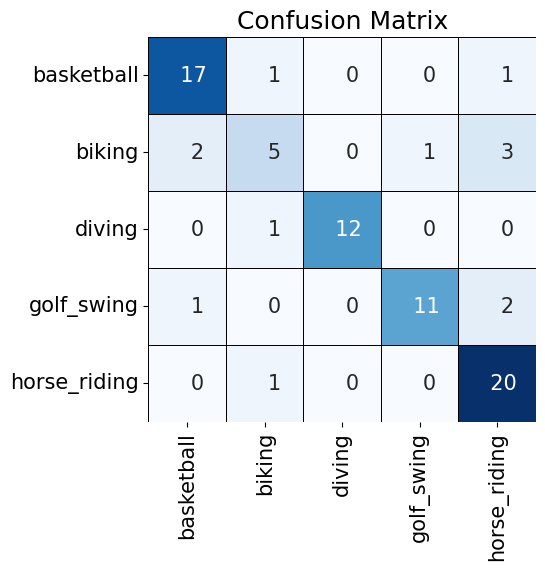

In [ ]:
plt.figure(figsize=(5,5))
plt.rcParams['font.size']=15
sns.heatmap(data=confusion_matrix(y_true=true_labels,y_pred=model_labels),
            cmap=plt.cm.Blues,
            annot=True,
            fmt='4d',
            cbar=False,
            linecolor='black',
            linewidths=0.5,
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title(label='Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Model Saving

In [33]:
model.save(filepath='model/ConvolutionalLongShortTermMemory_model.h5')